<a href="https://github.com/mrdbourke/pytorch-deep-learning/blob/main/07_pytorch_experiment_tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# (WIP) 07. PyTorch Experiment Tracking

TK - purpose of this notebook? what question does it answer?

This notebook tries several different models with different types of data augmentation and tracks the results to compare them.

* TK - What is experiment tracking?
* TK - Why track experiments?
* TK - Different ways to track experiments (CSV file, TensorBoard, W&B, MLFlow, etc...)
* TK - What we're going to cover

Start with one model + tracking experiments, then upgrade to more.

## TK 0. Getting setup 

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

### Setup device

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## TK 1. Get data

In [3]:
import os
import zipfile

from pathlib import Path

import requests

def download_data(source: str, 
                  destination: str,
                  remove_source: bool = True) -> Path:
    """Downloads a zipped dataset from source and unzips to destination.

    Args:
        source (str): A link to a zipped file containing data.
        destination (str): A target directory to unzip data to.
        remove_source (bool): Whether to remove the source after downloading and extracting.
    
    Returns:
        pathlib.Path to downloaded data.
    
    Example usage:
        download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                      destination="pizza_steak_sushi")
    """
    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path / destination

    # If the image folder doesn't exist, download it and prepare it... 
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)
        
        # Download pizza, steak, sushi data
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)

        # Unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...") 
            zip_ref.extractall(image_path)

        # Remove .zip file
        if remove_source:
            os.remove(data_path / target_file)
    
    return image_path

image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

## TK 2. Create Datasets and DataLoaders

In [4]:
# Setup dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

# Setup ImageNet normalization levels (turns all images into similar distribution as ImageNet)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Create starter transform
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])           

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=simple_transform,
    batch_size=32
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f7046cd2280>,
 ['pizza', 'steak', 'sushi'])

## TK 3. Getting a pretrained model, freezing the base layers and changing the classifier head

In [5]:
model = torchvision.models.efficientnet_b0(pretrained=True).to(device)
# model

In [6]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Update the classifier
model.classifier = torch.nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(1280, len(class_names)).to(device))

# Freeze all base layers 
for param in model.features.parameters():
    param.requires_grad = False

## TK 4. Train model and track results

In [7]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### TK Adjust training function to track results with `SummaryWriter`

See `SummaryWriter()` here: https://pytorch.org/docs/stable/tensorboard.html


In [8]:
model.name = "EfficietNetB0"
model.name

'EfficietNetB0'

In [9]:
from torch.utils.tensorboard import SummaryWriter
from going_modular.going_modular.engine import train_step, test_step

writer = SummaryWriter()

* TK - Now to use the writer, we've got to adjust the `train()` function from `engine.py`...
* TK - `train()` is from: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/going_modular/going_modular/engine.py 

In [10]:
from typing import Dict, List
from tqdm.auto import tqdm
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.
    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.
    Calculates, prints and stores evaluation metrics throughout.
    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").
    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]} 
    For example if training for epochs=2: 
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        # Add results to SummaryWriter
        writer.add_scalars(main_tag="Loss", 
                           tag_scalar_dict={"train_loss": train_loss,
                                            "test_loss": test_loss},
                           global_step=epoch)
        writer.add_scalars(main_tag="Accuracy", 
                           tag_scalar_dict={"train_acc": train_acc,
                                            "test_acc": test_acc}, 
                           global_step=epoch)
    
    # Close the writer
    writer.close()

    # Return the filled results at the end of the epochs
    return results

In [11]:
# Train model
# Note: Not using engine.train() since the original script isn't updated
results = train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=5,
                device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0520 | train_acc: 0.4961 | test_loss: 0.9212 | test_acc: 0.4782
Epoch: 2 | train_loss: 0.8743 | train_acc: 0.6875 | test_loss: 0.8136 | test_acc: 0.6203
Epoch: 3 | train_loss: 0.8097 | train_acc: 0.6523 | test_loss: 0.7196 | test_acc: 0.8258
Epoch: 4 | train_loss: 0.7096 | train_acc: 0.7578 | test_loss: 0.5920 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.5999 | train_acc: 0.9062 | test_loss: 0.5689 | test_acc: 0.8864


## TK 5. View the above in TensorBoard...

TK - What is TensorBoard?

TK You can view the training results above in TensorBoard in a number of ways:

| Code environment | How to view TensorBoard | Resource |
| ----- | ----- | ----- |
| VS Code (notebooks or Python scripts) | Press `SHIFT + CMD + P` to open the Command Palette and search for the command "Python: Launch TensorBoard". | [VS Code Guide on TensorBoard and PyTorch](https://code.visualstudio.com/docs/datascience/pytorch-support#_tensorboard-integration) |
| Jupyter and Colab Notebooks | Make sure [TensorBoard is installed](https://pypi.org/project/tensorboard/), load it with `%load_ext tensorboard` and then view your results with `%tensorboard --logdir DIR_WITH_LOGS`. | [`torch.utils.tensorboard`](https://pytorch.org/docs/stable/tensorboard.html) and [Get started with TensorBoard](https://www.tensorflow.org/tensorboard/get_started) |

You can also upload your experiments to [tensorboard.dev](https://tensorboard.dev/) to share them publicly with others.

In [12]:
# Example code to run in Google Colab
%load_ext tensorboard
%tensorboard --logdir runs

Reusing TensorBoard on port 6006 (pid 1168517), started 2 days, 3:10:48 ago. (Use '!kill 1168517' to kill it.)

## TK 6. Create a helper function to build `SummaryWriter()` instances

In [35]:
from datetime import datetime
datetime.now().strftime("%Y-%m-%d")

'2022-06-02'

In [36]:
def create_writer(experiment_name, model_name, extra=None):
    # TK - docstring

    # Get timestamp of current date (all experiments on certain day live in same folder)
    timestamp = datetime.now().strftime("%Y-%m-%d")

    if extra:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
    print(f"Created SummaryWriter and saving to {log_dir}...")
    return SummaryWriter(log_dir=log_dir)

In [37]:
# Add create_writer() to train()
from typing import Dict, List
from tqdm.auto import tqdm
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device, 
          writer: torch.utils.tensorboard.writer.SummaryWriter) -> Dict[str, List]:
    """Trains and tests a PyTorch model.
    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
      model: A PyTorch model to be trained and tested.
      train_dataloader: A DataLoader instance for the model to be trained on.
      test_dataloader: A DataLoader instance for the model to be tested on.
      optimizer: A PyTorch optimizer to help minimize the loss function.
      loss_fn: A PyTorch loss function to calculate loss on both datasets.
      epochs: An integer indicating how many epochs to train for.
      device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
      A dictionary of training and testing loss as well as training and
      testing accuracy metrics. Each metric has a value in a list for 
      each epoch.
      In the form: {train_loss: [...],
                train_acc: [...],
                test_loss: [...],
                test_acc: [...]} 
      For example if training for epochs=2: 
              {train_loss: [2.0616, 1.0537],
                train_acc: [0.3945, 0.3945],
                test_loss: [1.2641, 1.5706],
                test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        if writer:
            # Add results to SummaryWriter
            writer.add_scalars(main_tag="Loss", 
                               tag_scalar_dict={"train_loss": train_loss,
                                                "test_loss": test_loss},
                               global_step=epoch)
            writer.add_scalars(main_tag="Accuracy", 
                               tag_scalar_dict={"train_acc": train_acc,
                                                "test_acc": test_acc}, 
                               global_step=epoch)

            # Close the writer
            writer.close()
        else:
            pass
    
    # Close the writer
    writer.close()

    # Return the filled results at the end of the epochs
    return results

## TK - 7. Setting up a series of modelling experiments

TK - turn this into a table...

TK - experiments to track:
- model_0 = 10% data, effnet_b0, 5 epochs
- model_1 = 10% data, effnet_b0, 10 epochs (double training time)
- model_2 = 20% data, effnet_b0, 5 epochs (double data)
- model_3 = 10% data, effnet_b2, 5 epochs (double model parameters)
- 2 x epochs, 2 x models, 2 x datasets = 6 models total

See a list of Torch pretrained models here: https://pytorch.org/vision/stable/models.html, all pretrained models are expected to have data inputs that are normalized with the following:
```python
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
```                                


In [38]:
from torchvision import transforms

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

simple_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

### TK - Load data

* TK - Create two datasets for:
    * Train with 10% of data
    * Train with 20% of data
* TK - See how the data was created: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb 

In [39]:
data_10_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                                     destination="pizza_steak_sushi")

data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

[INFO] data/pizza_steak_sushi directory exists, skipping download.
[INFO] data/pizza_steak_sushi_20_percent directory exists, skipping download.


In [40]:
# Setup training directory paths
train_dir_10_percent = data_10_percent_path / "train"
train_dir_20_percent = data_20_percent_path / "train"

# Setup testing directory paths (note: use the same test dataset for both to compare the results)
test_dir = data_10_percent_path / "test"

In [41]:
# Create 10% dataloaders
train_dataloader_10_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_10_percent,
    test_dir=test_dir,
    transform=simple_transform,
    batch_size=32
)

# Create 20% dataloaders
train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
    test_dir=test_dir,
    transform=simple_transform,
    batch_size=32
)

# TK - number of samples/batches per dataloader (using the same test_dataloader for both experiments)
len(train_dataloader_10_percent), len(train_dataloader_20_percent), len(test_dataloader), len(class_names)

(8, 15, 3, 3)

### TK Setup models

* **Note:** Many modern models can handle input images of varying sizes thanks to [`torch.nn.AdaptiveAvgPool2d()`](https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html), this layer adaptively adjusts the `output_size` of a given input as required. You can try this out by passing different size input images to `summary()` or your models.

In [42]:
effnetb2 = torchvision.models.efficientnet_b2(pretrained=True).to(device)
# summary(model=effnetb2, 
#         input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
#         # col_names=["input_size"], # uncomment for smaller output
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"]
# ) 

In [43]:
# Get the number of in_features of the EfficientNetB2 classifier layer
len(effnetb2.classifier.state_dict()["1.weight"][0])

1408

In [44]:
import torchvision
from torch import nn

# Set seeds
def set_seeds(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

# Get num out features
OUT_FEATURES = len(class_names)

# EfficientNetB0
def create_effnetb0():
    # Get the base mdoel
    model = torchvision.models.efficientnet_b0(pretrained=True).to(device)

    # Free the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # Change the classifier head
    set_seeds()
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features=1280, out_features=OUT_FEATURES)
    ).to(device)

    # Give the model a name
    model.name = "effnetb0"
    print(f"[INFO] Creating new {model.name} model.")
    return model

# EfficientNetB2
def create_effnetb2():
    # Get the base model
    model = torchvision.models.efficientnet_b2(pretrained=True).to(device)

    # Change the classifier head
    set_seeds()
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(in_features=1408, out_features=OUT_FEATURES)
    ).to(device)

    # Free the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # Give the model a name
    model.name = "effnetb2"
    print(f"[INFO] Creating new {model.name} model.")
    return model

## Create experiments

In [45]:
# Create epochs list
num_epochs = [5, 10]

# Create models list (need to create a new model for each experiment)
models = ["effnetb0", "effnetb2"]

# Create dataloaders dictionary for various dataloaders
train_dataloaders = {"data_10_percent": train_dataloader_10_percent,
                     "data_20_percent": train_dataloader_20_percent}

In [51]:
%%time
from going_modular.going_modular.utils import save_model

# Set the random seeds
set_seeds()

# Loop through each DataLoader
for dataloader_name, train_dataloader in train_dataloaders.items():

    # Loop through each number of epochs
    for epochs in num_epochs: 

        # Loop through each model name and create a new model based on the name
        for model_name in models:

            # Select the model
            if model_name == "effnetb0":
                model = create_effnetb0()
            else:
                model = create_effnetb2()
            
            # Create information print outs
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Training for {epochs} epochs")
            print(f"----------")        
            
            # Create a new loss and optimizer for every model
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

            # Train target model with target dataloaders and track experiments
            train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader, 
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=epochs,
                device=device,
                writer=create_writer(experiment_name=dataloader_name,
                                    model_name=model_name,
                                    extra=f"{epochs}_epochs"
                ))
            
            # Save the model to file so we can get back the best model
            save_filepath = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            print(f"[INFO] Saving model to {save_filepath}")
            save_model(model=model,
                       target_dir="models",
                       model_name=save_filepath)
            print("----------\n")

[INFO] Creating new effnetb0 model.
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Training for 5 epochs
----------
Created SummaryWriter and saving to runs/2022-06-02/data_10_percent/effnetb0/_5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0520 | train_acc: 0.4961 | test_loss: 0.9212 | test_acc: 0.4782
Epoch: 2 | train_loss: 0.8743 | train_acc: 0.6875 | test_loss: 0.8136 | test_acc: 0.6203
Epoch: 3 | train_loss: 0.8097 | train_acc: 0.6523 | test_loss: 0.7196 | test_acc: 0.8258
Epoch: 4 | train_loss: 0.7096 | train_acc: 0.7578 | test_loss: 0.5920 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.5999 | train_acc: 0.9062 | test_loss: 0.5689 | test_acc: 0.8864
[INFO] Saving model to 07_effnetb0_data_10_percent_5_epochs.pth
[INFO] Saving model to: models/07_effnetb0_data_10_percent_5_epochs.pth
----------

[INFO] Creating new effnetb2 model.
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Training for 5 epochs
----------
Created SummaryWriter and saving to runs/2022-06-02/data_10_percent/effnetb2/_5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0914 | train_acc: 0.3867 | test_loss: 0.9558 | test_acc: 0.6610
Epoch: 2 | train_loss: 0.9239 | train_acc: 0.6445 | test_loss: 0.8713 | test_acc: 0.8144
Epoch: 3 | train_loss: 0.8080 | train_acc: 0.7578 | test_loss: 0.7511 | test_acc: 0.9072
Epoch: 4 | train_loss: 0.7182 | train_acc: 0.8867 | test_loss: 0.7161 | test_acc: 0.9081
Epoch: 5 | train_loss: 0.6847 | train_acc: 0.7656 | test_loss: 0.7087 | test_acc: 0.8873
[INFO] Saving model to 07_effnetb2_data_10_percent_5_epochs.pth
[INFO] Saving model to: models/07_effnetb2_data_10_percent_5_epochs.pth
----------

[INFO] Creating new effnetb0 model.
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Training for 10 epochs
----------
Created SummaryWriter and saving to runs/2022-06-02/data_10_percent/effnetb0/_10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0520 | train_acc: 0.4961 | test_loss: 0.9212 | test_acc: 0.4782
Epoch: 2 | train_loss: 0.8743 | train_acc: 0.6875 | test_loss: 0.8136 | test_acc: 0.6203
Epoch: 3 | train_loss: 0.8097 | train_acc: 0.6523 | test_loss: 0.7196 | test_acc: 0.8258
Epoch: 4 | train_loss: 0.7096 | train_acc: 0.7578 | test_loss: 0.5920 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.5999 | train_acc: 0.9062 | test_loss: 0.5689 | test_acc: 0.8864
Epoch: 6 | train_loss: 0.5619 | train_acc: 0.8945 | test_loss: 0.5964 | test_acc: 0.8864
Epoch: 7 | train_loss: 0.5578 | train_acc: 0.7891 | test_loss: 0.5590 | test_acc: 0.8864
Epoch: 8 | train_loss: 0.4700 | train_acc: 0.9492 | test_loss: 0.5199 | test_acc: 0.8759
Epoch: 9 | train_loss: 0.5729 | train_acc: 0.7695 | test_loss: 0.5120 | test_acc: 0.8873
Epoch: 10 | train_loss: 0.4782 | train_acc: 0.8242 | test_loss: 0.4650 | test_acc: 0.9072
[INFO] Saving model to 07_effnetb0_data_10_percent_10_epochs.pth
[INFO] Saving model to: models/07_effnetb0_d

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0914 | train_acc: 0.3867 | test_loss: 0.9558 | test_acc: 0.6610
Epoch: 2 | train_loss: 0.9239 | train_acc: 0.6445 | test_loss: 0.8713 | test_acc: 0.8144
Epoch: 3 | train_loss: 0.8080 | train_acc: 0.7578 | test_loss: 0.7511 | test_acc: 0.9072
Epoch: 4 | train_loss: 0.7182 | train_acc: 0.8867 | test_loss: 0.7161 | test_acc: 0.9081
Epoch: 5 | train_loss: 0.6847 | train_acc: 0.7656 | test_loss: 0.7087 | test_acc: 0.8873
Epoch: 6 | train_loss: 0.6115 | train_acc: 0.7891 | test_loss: 0.6332 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.6124 | train_acc: 0.8008 | test_loss: 0.6401 | test_acc: 0.8769
Epoch: 8 | train_loss: 0.5196 | train_acc: 0.9336 | test_loss: 0.6201 | test_acc: 0.8977
Epoch: 9 | train_loss: 0.5421 | train_acc: 0.8086 | test_loss: 0.6231 | test_acc: 0.8769
Epoch: 10 | train_loss: 0.4919 | train_acc: 0.8086 | test_loss: 0.5879 | test_acc: 0.8873
[INFO] Saving model to 07_effnetb2_data_10_percent_10_epochs.pth
[INFO] Saving model to: models/07_effnetb2_d

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9588 | train_acc: 0.6125 | test_loss: 0.6551 | test_acc: 0.8655
Epoch: 2 | train_loss: 0.6894 | train_acc: 0.8521 | test_loss: 0.5800 | test_acc: 0.8873
Epoch: 3 | train_loss: 0.5805 | train_acc: 0.8604 | test_loss: 0.4576 | test_acc: 0.9176
Epoch: 4 | train_loss: 0.4937 | train_acc: 0.8646 | test_loss: 0.4454 | test_acc: 0.9176
Epoch: 5 | train_loss: 0.4886 | train_acc: 0.8500 | test_loss: 0.3913 | test_acc: 0.9176
[INFO] Saving model to 07_effnetb0_data_20_percent_5_epochs.pth
[INFO] Saving model to: models/07_effnetb0_data_20_percent_5_epochs.pth
----------

[INFO] Creating new effnetb2 model.
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Training for 5 epochs
----------
Created SummaryWriter and saving to runs/2022-06-02/data_20_percent/effnetb2/_5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9819 | train_acc: 0.5604 | test_loss: 0.7775 | test_acc: 0.8049
Epoch: 2 | train_loss: 0.7298 | train_acc: 0.8021 | test_loss: 0.6665 | test_acc: 0.8873
Epoch: 3 | train_loss: 0.6011 | train_acc: 0.8458 | test_loss: 0.5633 | test_acc: 0.9280
Epoch: 4 | train_loss: 0.5429 | train_acc: 0.8354 | test_loss: 0.5685 | test_acc: 0.8977
Epoch: 5 | train_loss: 0.4410 | train_acc: 0.8708 | test_loss: 0.4470 | test_acc: 0.9384
[INFO] Saving model to 07_effnetb2_data_20_percent_5_epochs.pth
[INFO] Saving model to: models/07_effnetb2_data_20_percent_5_epochs.pth
----------

[INFO] Creating new effnetb0 model.
[INFO] Model: effnetb0
[INFO] DataLoader: data_20_percent
[INFO] Training for 10 epochs
----------
Created SummaryWriter and saving to runs/2022-06-02/data_20_percent/effnetb0/_10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9588 | train_acc: 0.6125 | test_loss: 0.6551 | test_acc: 0.8655
Epoch: 2 | train_loss: 0.6894 | train_acc: 0.8521 | test_loss: 0.5800 | test_acc: 0.8873
Epoch: 3 | train_loss: 0.5805 | train_acc: 0.8604 | test_loss: 0.4576 | test_acc: 0.9176
Epoch: 4 | train_loss: 0.4937 | train_acc: 0.8646 | test_loss: 0.4454 | test_acc: 0.9176
Epoch: 5 | train_loss: 0.4886 | train_acc: 0.8500 | test_loss: 0.3913 | test_acc: 0.9176
Epoch: 6 | train_loss: 0.3708 | train_acc: 0.8833 | test_loss: 0.3565 | test_acc: 0.9072
Epoch: 7 | train_loss: 0.3558 | train_acc: 0.9208 | test_loss: 0.3182 | test_acc: 0.9072
Epoch: 8 | train_loss: 0.3739 | train_acc: 0.8938 | test_loss: 0.3346 | test_acc: 0.8977
Epoch: 9 | train_loss: 0.2975 | train_acc: 0.9375 | test_loss: 0.3088 | test_acc: 0.9280
Epoch: 10 | train_loss: 0.3625 | train_acc: 0.8479 | test_loss: 0.2771 | test_acc: 0.9072
[INFO] Saving model to 07_effnetb0_data_20_percent_10_epochs.pth
[INFO] Saving model to: models/07_effnetb0_d

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9819 | train_acc: 0.5604 | test_loss: 0.7775 | test_acc: 0.8049
Epoch: 2 | train_loss: 0.7298 | train_acc: 0.8021 | test_loss: 0.6665 | test_acc: 0.8873
Epoch: 3 | train_loss: 0.6011 | train_acc: 0.8458 | test_loss: 0.5633 | test_acc: 0.9280
Epoch: 4 | train_loss: 0.5429 | train_acc: 0.8354 | test_loss: 0.5685 | test_acc: 0.8977
Epoch: 5 | train_loss: 0.4410 | train_acc: 0.8708 | test_loss: 0.4470 | test_acc: 0.9384
Epoch: 6 | train_loss: 0.3876 | train_acc: 0.9125 | test_loss: 0.4564 | test_acc: 0.8977
Epoch: 7 | train_loss: 0.3481 | train_acc: 0.9271 | test_loss: 0.4227 | test_acc: 0.9384
Epoch: 8 | train_loss: 0.3861 | train_acc: 0.8792 | test_loss: 0.4350 | test_acc: 0.9280
Epoch: 9 | train_loss: 0.3315 | train_acc: 0.8979 | test_loss: 0.4254 | test_acc: 0.9081
Epoch: 10 | train_loss: 0.3382 | train_acc: 0.8979 | test_loss: 0.3909 | test_acc: 0.9384
[INFO] Saving model to 07_effnetb2_data_20_percent_10_epochs.pth
[INFO] Saving model to: models/07_effnetb2_d

## View experiments in TensorBoard

* TK - See example notebook: https://colab.research.google.com/github/tensorflow/tensorboard/blob/master/docs/tensorboard_in_notebooks.ipynb#scrollTo=GUSM8yLrO2yZ 

In VSCode:
* Press `Shift + Cmd + P` (to open the Command Palette)
* Search "Launch TensorBoard"
* Press `Enter`

In [49]:
# Viewing TensorBoard in Jupyter and Google Colab Notebooks
%load_ext tensorboard
%tensorboard --logdir runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 1168517), started 2 days, 3:34:54 ago. (Use '!kill 1168517' to kill it.)

## TK - Load in the best model and make predictions with it

TK - best model = effnetb2 + 10 epochs + 20% data (double parameters, double data, double training time)

In [53]:
best_model_path = "models/07_effnetb2_data_20_percent_10_epochs.pth"

best_model = create_effnetb2()
best_model.load_state_dict(torch.load(best_model_path))

[INFO] Creating new effnetb2 model.


<All keys matched successfully>

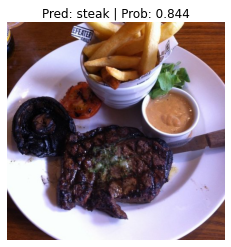

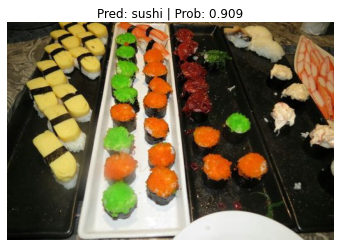

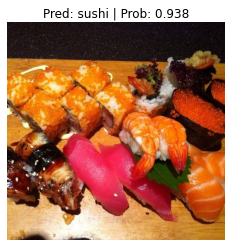

In [58]:
# TK - import function from previously created section: https://www.learnpytorch.io/06_pytorch_transfer_learning/#6-make-predictions-on-images-from-the-test-set 
from going_modular.going_modular.predictions import pred_and_plot_image

# Get a random list of 3 images from 20% test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(data_20_percent_path / "test").glob("*/*.jpg")) # get all test image paths from 20% dataset
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot)

for image_path in test_image_path_sample:
    pred_and_plot_image(model=best_model,
                        image_path=image_path,
                        class_names=class_names,
                        image_size=(224, 224))

### TK - Predict on a custom image with the best model

data/04-pizza-dad.jpeg already exists, skipping download.


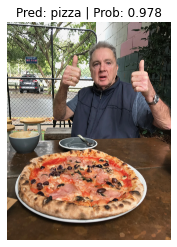

In [61]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = Path("data/04-pizza-dad.jpeg")

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)

## Exercises
* Add functionality to save the best model?
* Scale up the dataset (e.g. could use *all* of Food101 + track experiment)
* Introduce data augmentation to the list of experiments, does this change anything?
* Could use the following for data augmentation:

```python
# Note: Data augmentation transform like this should only be performed on training data
train_transform_data_aug = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor(),
    normalize
])

# And to view images...
def view_dataloader_images(dataloader, n=10):
    if n > 10:
        print(f"Having n higher than 10 will create messy plots, lowering to 10.")
        n = 10
    imgs, labels = next(iter(train_dataloader_aug))
    plt.figure(figsize=(16, 8))
    for i in range(n):
        # Min max scale the image for display purposes
        targ_image = imgs[i]
        sample_min, sample_max = targ_image.min(), targ_image.max()
        sample_scaled = (targ_image - sample_min)/(sample_max - sample_min)

        # Plot images with appropriate axes information
        plt.subplot(1, 10, i+1)
        plt.imshow(sample_scaled.permute(1, 2, 0)) # resize for Matplotlib requirements
        plt.title(class_names[labels[i]])
        plt.axis(False)

# Have to update `create_dataloaders()` to handle different augmentations
import os
from torch.utils.data import DataLoader
from torchvision import datasets

NUM_WORKERS = os.cpu_count() # use maximum number of CPUs for workers to load data 

# Note: this is an update version of data_setup.create_dataloaders to handle
# differnt train and test transforms.
def create_dataloaders(
    train_dir, 
    test_dir, 
    train_transform, # add parameter for train transform (transforms on train dataset)
    test_transform,  # add parameter for test transform (transforms on test dataset)
    batch_size=32, num_workers=NUM_WORKERS
):
    # Use ImageFolder to create dataset(s)
    train_data = datasets.ImageFolder(train_dir, transform=train_transform)
    test_data = datasets.ImageFolder(test_dir, transform=test_transform)

    # Get class names
    class_names = train_data.classes

    # Turn images into data loaders
    train_dataloader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )
    test_dataloader = DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )

    return train_dataloader, test_dataloader, class_names
```

## Extra-curriculum

* See here for more on the profiler: https://pytorch.org/blog/introducing-pytorch-profiler-the-new-and-improved-performance-tool/
* See here on setting up TensorBoard in VSCode: https://code.visualstudio.com/docs/datascience/pytorch-support
* See more on ML experiment tracking - https://madewithml.com/courses/mlops/experiment-tracking/ 
* Does changing the data input size to EfficientNetB4 change its results? E.g. input image size of (380, 380) instead of (224, 224)?

<div class="alert alert-block alert-warning">
<b>Example:</b> Use yellow boxes for examples that are not 
inside code cells, or use for mathematical formulas if needed.
</div>